In [452]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1181]:
import numpy as np
import seaborn as sns
sns.set()
sns.set_theme(style='white')
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter, defaultdict
from llm_knowledge.epistemic_diversity import (
    calculate_probabilities, 
    calculate_entropy, 
    calculate_evenness, 
    calculate_divergence, 
    calculate_evenness_statement, 
    calculate_diversity,
    calculate_entropies_progressive,
    estimate_coverage,
    resample_to_coverage_level,
    filter_dframe
)
import json
from tqdm import tqdm
from matplotlib.lines import Line2D
import matplotlib as mpl
from scipy.spatial.distance import jensenshannon
from statsmodels.formula.api import ols, mixedlm
from pathlib import Path
from langdetect import detect
from collections import Counter
from llm_knowledge.epistemic_diversity import embed_sentences
from sklearn.cluster import DBSCAN
from pathlib import Path



# Step 1: Collect all the data and topics, calculate the distributions, entropy, and evenness

In [2001]:
cluster_dir = 'LOCATION OF CLUSTER DIRECTORY'

# Read in the model categories
with open('./data/model_categories.json') as f:
    model_categories = json.load(f)

# Read in the topics
with open('./data/topics.txt') as f:
    topics = [l.strip() for l in f]

topic_to_country = {}
with open('./data/countries.txt') as f:
    for j,l in enumerate(f):
        topic_to_country[topics[j]] = l.strip()

model_to_name = {
    "meta-llama/Llama-2-7b-chat-hf": "Llama2 7b",
    "meta-llama/Llama-3.1-8B-Instruct": 'Llama3.1 8b',
    "meta-llama/Llama-3.2-3B-Instruct": 'Llama3.2 3b',
    "meta-llama/Llama-2-13b-chat-hf": 'Llama2 13b',
    "meta-llama/Llama-2-70b-chat-hf": 'Llama2 70b',
    "meta-llama/Llama-3.1-70B-Instruct": 'Llama3.1 70B',
    "meta-llama/Llama-3.3-70B-Instruct": 'Llama3.3 70B',
    "google/gemma-2b-it": 'Gemma1 2b',
    "google/gemma-2-2b-it": 'Gemma2 2b',
    "google/gemma-3-1b-it": 'Gemma3 1b',
    "google/gemma-1.1-7b-it": 'Gemma1.1 7b',
    "google/gemma-2-9b-it": 'Gemma2 9b',
    "google/gemma-3-12b-it": 'Gemma3 12b',
    "google/gemma-2-27b-it": 'Gemma2 27b',
    "google/gemma-3-27b-it": 'Gemma3 27b',
    "Qwen/Qwen1.5-7B-Chat": 'Qwen1.5 7b',
    "Qwen/Qwen2.5-7B-Instruct": 'Qwen2.5 7b',
    "Qwen/Qwen3-8B": 'Qwen3 8b',
    "Qwen/Qwen1.5-14B-Chat": 'Qwen1.5 14b',
    "Qwen/Qwen2.5-14B-Instruct": 'Qwen2.5 14b',
    "Qwen/Qwen3-14B": 'Qwen3 14B',
    "Qwen/Qwen1.5-72B-Chat": 'Qwen1.5 72b',
    "Qwen/Qwen2.5-72B-Instruct": 'Qwen2.5 72B',
    "Qwen/Qwen3-32B": 'Qwen3 32b',
    "gpt-3.5-turbo-0125": 'GPT 3.5 Turbo',
    "gpt-4o-2024-08-06": 'GPT 4o',
    "gpt-5-2025-08-07": 'GPT 5',
    'search': 'Search'
}

family_to_name = {
    'llama': 'Llama',
    'gemma': 'Gemma',
    'qwen': 'Qwen',
    'openai': 'OpenAI',
    'search': 'Search'
}

In [2002]:
# First, calculate the topic level coverages
topic_to_coverages = defaultdict(list)
for t in tqdm(topics):
    # Read in the topic dframe
    if Path(f"{cluster_dir}/{t}.done").exists():
        dframe = pd.read_parquet(f"{cluster_dir}/{t}.pqt")
        present_models = set(dframe['model_id'].to_list())
        # Go through all of the models and calculate the scores
        for family in model_categories:
            for setting in model_categories[family]:
                for model in model_categories[family][setting]['models']:
                    if model not in present_models:
                        continue
                    topic_to_coverages[t].append(estimate_coverage(dframe, group_keys=['model_id', 'setting'], group_values=[model, 'ift'], return_type='list'))
    
                    if 'openai' != family:
                        topic_to_coverages[t].append(estimate_coverage(dframe, group_keys=['model_id', 'setting'], group_values=[model, 'rag'], return_type='list'))
                    

100%|█████████████████████████████████████████| 155/155 [03:48<00:00,  1.48s/it]


In [ ]:
# Calculate all of the entropies
model_stats = { 
    'ift': defaultdict(lambda: {'entropy': [], 'hillshannon': [], 'probabilities': [], 'topic': []}),
    'rag': defaultdict(lambda: {'entropy': [], 'hillshannon': [], 'probabilities': [], 'topic': []}),
    'other': defaultdict(lambda: {'entropy': [], 'hillshannon': [], 'probabilities': [], 'topic': []})
}
for t in tqdm(topics):
    # Read in the topic dframe
    if Path(f"{cluster_dir}/{t}.done").exists():
        min_cov = min(topic_to_coverages[t])
        dframe = pd.read_parquet(f"{cluster_dir}/{t}.pqt")
        present_models = set(dframe['model_id'].to_list())
        # Go through all of the models and calculate the scores
        for family in model_categories:
            for setting in model_categories[family]:
                for model in model_categories[family][setting]['models']:
                    if model not in present_models:
                        continue
                    sample_dframe = resample_to_coverage_level(dframe, group_keys=['model_id', 'setting'], group_values=[model, 'ift'], return_type='list', coverage_level=min_cov)
                    ent,hillshannon,probs = calculate_diversity(dframe, sampled_data=sample_dframe, group_keys=['model_id', 'setting'], group_values=[model, 'ift'], return_type='list')
                    model_stats['ift'][model]['entropy'].append(ent)
                    model_stats['ift'][model]['hillshannon'].append(hillshannon)
                    model_stats['ift'][model]['probabilities'].append(probs)
                    model_stats['ift'][model]['topic'].append(t)
    
                    if 'openai' != family:
                        sample_dframe = resample_to_coverage_level(dframe, group_keys=['model_id', 'setting'], group_values=[model, 'rag'], return_type='list', coverage_level=min_cov)
                        ent,hillshannon,probs = calculate_diversity(dframe, sampled_data=sample_dframe, group_keys=['model_id', 'setting'], group_values=[model, 'rag'], return_type='list')
                        model_stats['rag'][model]['entropy'].append(ent)
                        model_stats['rag'][model]['hillshannon'].append(hillshannon)
                        model_stats['rag'][model]['probabilities'].append(probs)
                        model_stats['rag'][model]['topic'].append(t)

        # Add search results
        sample_dframe = resample_to_coverage_level(dframe, group_keys=['model_id', 'setting'], group_values=['search', 'other'], return_type='list', coverage_level=min_cov)
        ent,hillshannon,probs = calculate_diversity(dframe, sampled_data=sample_dframe, group_keys=['model_id', 'setting'], group_values=['search', 'other'], return_type='list')
        model_stats['other']['search']['entropy'].append(ent)
        model_stats['other']['search']['hillshannon'].append(hillshannon)
        model_stats['other']['search']['probabilities'].append(probs)
        model_stats['other']['search']['topic'].append(t)

                

# Basic histograms of clusters

In [1599]:
# Get some samples to pick the representative
print_topics = ['democracy', 'free speech', 'Berlin Wall', 'K-pop']
for k,topic in enumerate(print_topics):
    dframe = pd.read_parquet(f"{cluster_dir}/{topic}.pqt")
    top_clusters = np.array([[c,v] for c,v in sorted(Counter(dframe['cluster'].to_list()).items(), key=lambda x: x[1], reverse=True)][:10])
    print("=============================================")
    for j,c in enumerate(top_clusters):
        examples = [s for s in dframe[dframe['cluster'] == c[0]]['factoid'].to_list() if len(s) < 60]
        sample_text = random.sample(examples, min(10, len(examples)))
        print('\n'.join(sample_text))
        print("-------------------------------------------")
    print("=============================================")

Democracy is rooted in the idea of popular sovereignty.
Popular sovereignty is a fundamental ideal of democracy.
Democracy is broadly defined as "rule by the people."
Democracy is about government by the people.
Democracy embodies principles such as popular sovereignty.
Democracy fundamentally means "rule of the people."
Democracy is a government for the people.
Democracy is by the people.
Democracy is defined as "power of the people."
Democracy is government by the people, for the people.
-------------------------------------------
Democracy is a continually evolving concept.
Democracy is an ever-shifting concept.
Democracy is a dynamic and evolving system.
The evolution of democracy is a dynamic process.
Democracy is an evolving concept.
Democracy's evolution includes its historical milestones.
Democracy is a complex and evolving system.
Democracy is constantly evolving.
Democracy is a complex and evolving system.
Democracy has evolved over time.
-------------------------------------

In [1614]:
reps = {
    "democracy": [
        'Democracy is a system in which power is held by the people.',
        'Democracy is a constantly adapting system.',
        'Democracy involves the principles of the rule of law.',
        'Free and fair elections are a core principle of democracy.',
        'Democracy is a system of representative government.',
        'Everyone deserves a voice in a global democracy.',
        'Democracy emphasizes accountability.',
        'Free speech is a fundamental principle of democracy.',
        'Democracy is not without its limitations.',
        'People elect officials to govern in a democracy.'
    ],
    "free speech": [
        'Free speech is essential for the functioning of democracy.',
        'The First Amendment in the US protects free speech.',
        'Free speech promotes the exchange of ideas.',
        'The right to free speech is not absolute.',
        'Free speech enables progress.',
        'Free speech enables us to hold those in power accountable.',
        'Free speech is a fundamental right.',
        'Free speech fosters open dialogue.',
        'The concept of free speech has various limitations.',
        'Free speech includes expression of ideas without restraint.'
    ],
    "Berlin Wall": [
        'The Berlin Wall became a powerful symbol of the Cold War.',
        'The Berlin Wall was built in the year 1961.',
        'The Berlin Wall fell in 1989.',
        'Families were separated by the Berlin Wall.',
        'The fall of the Berlin Wall marked the end of the Cold War.',
        'The fall of the Berlin Wall occurred on November 9, 1989.',
        'The Berlin Wall\'s construction had an impact.',
        'The legacy of the Berlin Wall continues to be felt today.',
        'The fall of the Berlin Wall led to German reunification.',
        'The Berlin Wall was more than just a physical barrier.'
    ],
    "K-pop": [
        'K-pop is a global cultural phenomenon.',
        'K-pop has cultural integration.',
        'K-pop tackles various themes.',
        'K-pop has an evolution.',
        'K-pop features elaborate choreography.',
        'K-Pop has a passionate community.',
        'K-pop has highly produced music videos.',
        'K-pop is more than just music.',
        'K-pop has had a significant impact on fashion.',
        'K-pop\'s influence impacts beauty.'
    ]
}

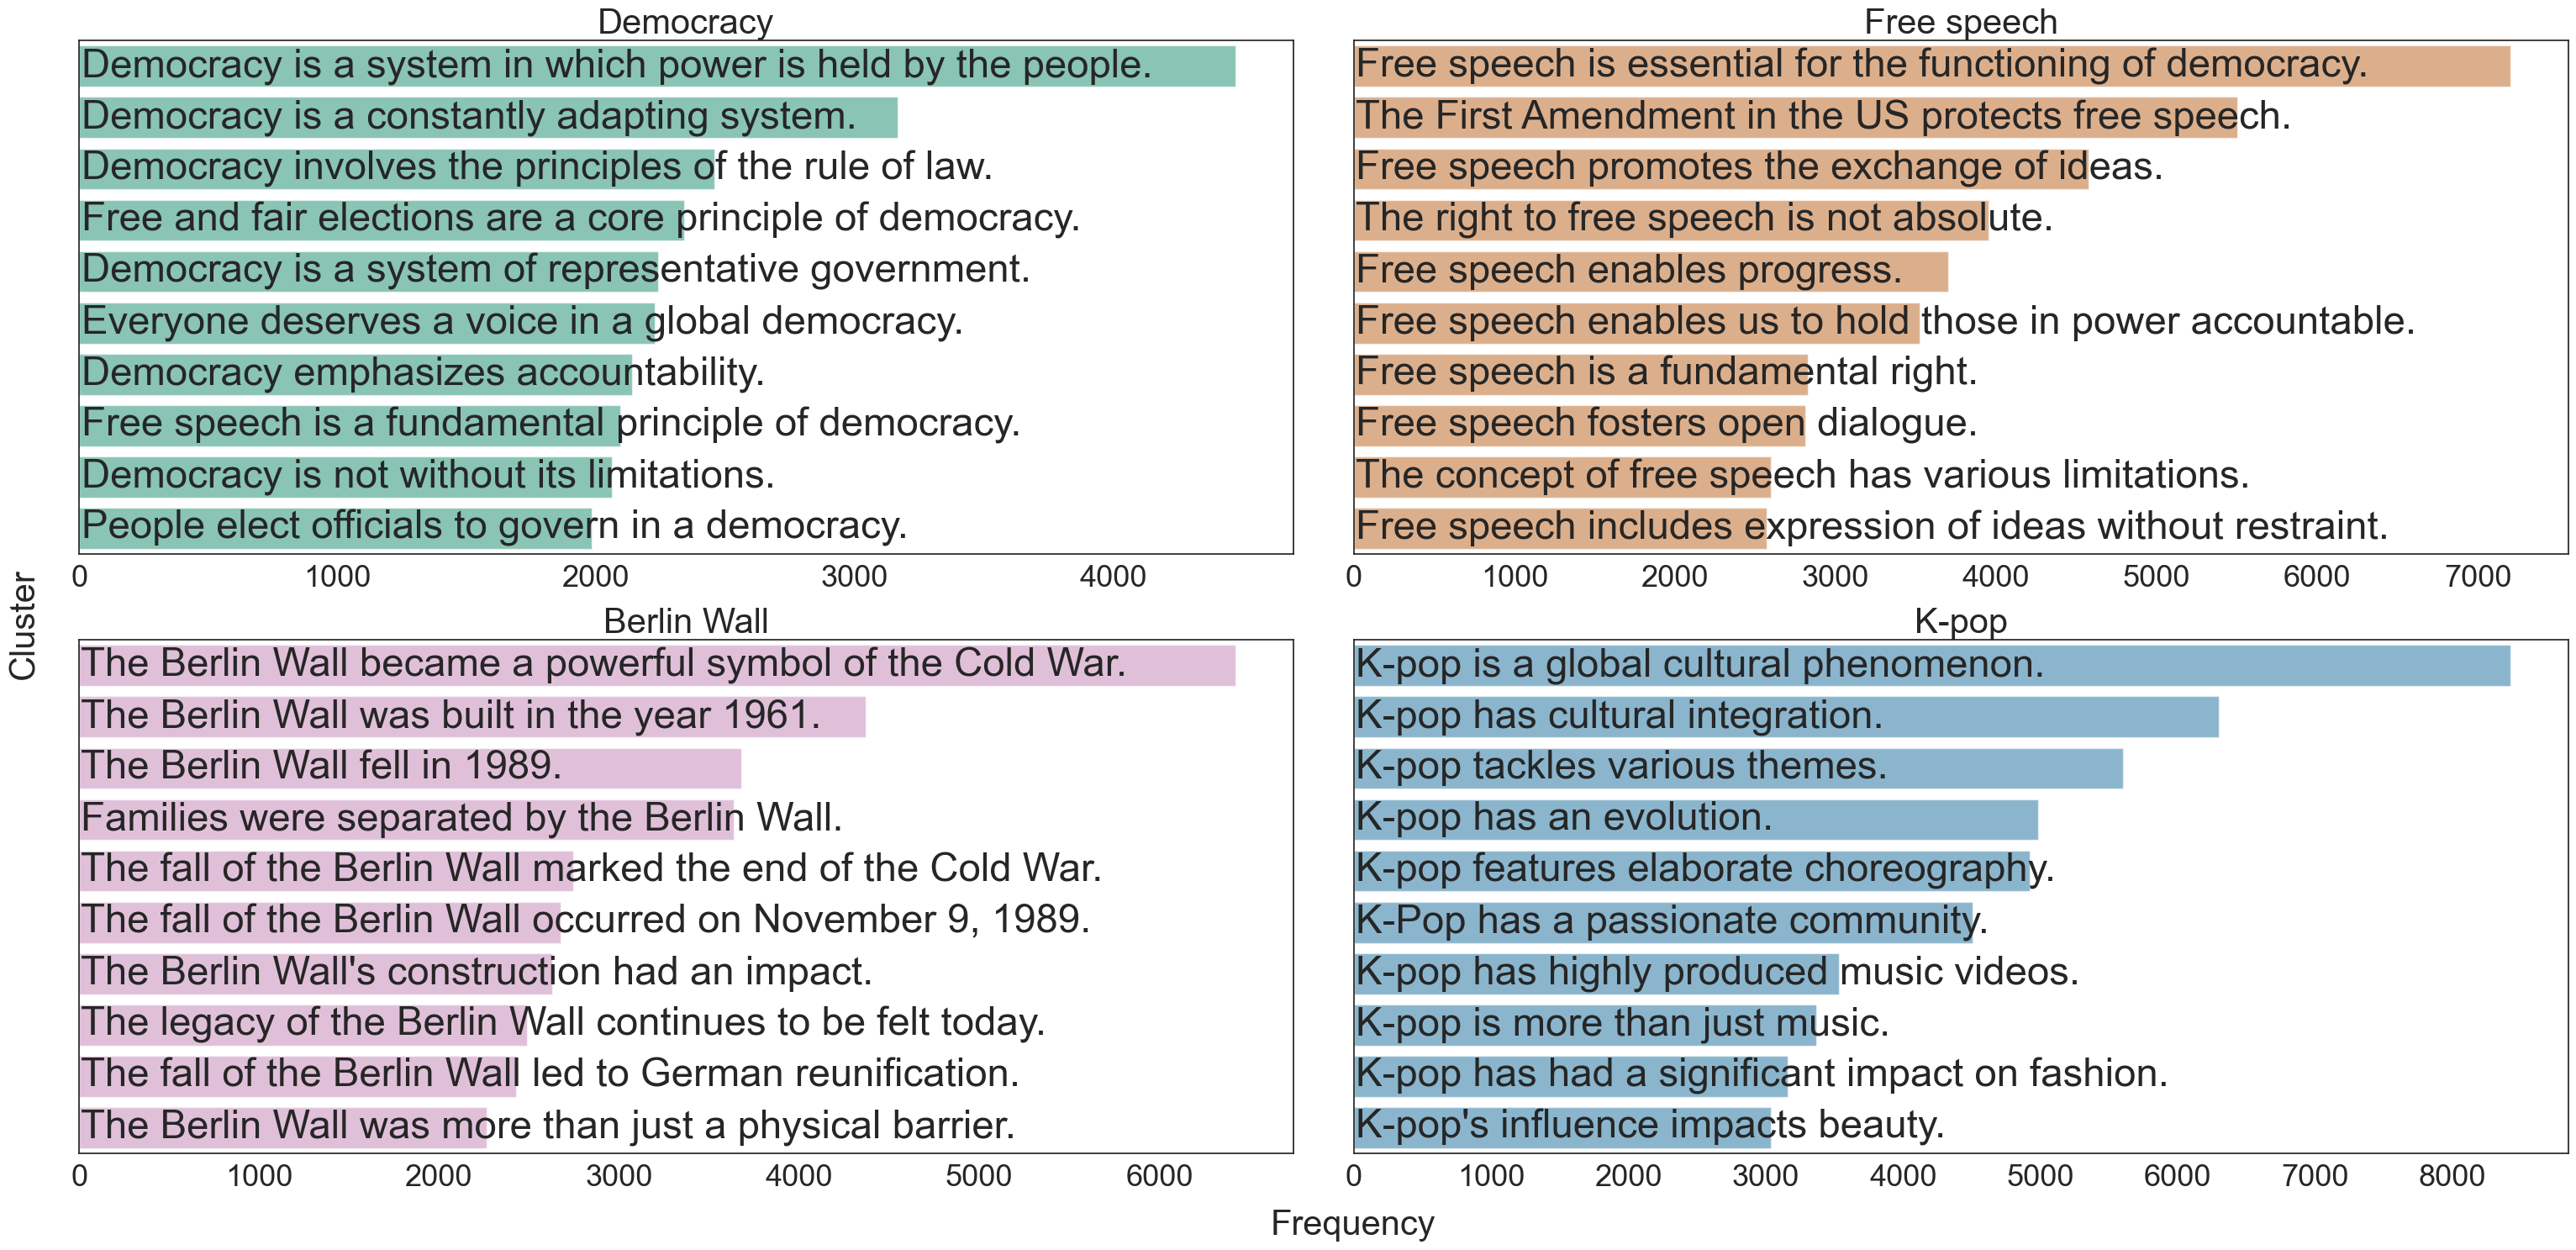

In [1619]:
fig,ax = plt.subplots(2,2,figsize=(32,15))
axes = [a for r in ax for a in r]
colors = [2,3,4,0]
for k,topic in enumerate(print_topics):
    ax = axes[k]
    palette = sns.color_palette('colorblind')[colors[k]]
    dframe = pd.read_parquet(f"{cluster_dir}/{topic}.pqt")
    top_clusters = np.array([[c,v] for c,v in sorted(Counter(dframe['cluster'].to_list()).items(), key=lambda x: x[1], reverse=True)][:10])
    sns.barplot(y=top_clusters[:,0], x=top_clusters[:,1], orient='h', order=top_clusters[:,0], ax=ax, alpha=0.5, color=palette)
    #ax.set_xticklabels([])
    ax.set_yticklabels([])
    for j,c in enumerate(top_clusters):
        text = reps[topic][j]
        ax.annotate(xy=(10,j), text=text, fontsize=34, ha='left', va='center')
    ax.set_title(topic[0].upper() + topic[1:],fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=26)
fig.supxlabel("Frequency",fontsize=30)
fig.supylabel("Cluster",fontsize=30,x=0)
plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig(f'./figures/clustervis/combined.pdf')
#dframe = dframe[dframe['model_id'] == 'search']

# RQ1: ID over time and model size

/Users/vcx366/anaconda3/envs/trope-values-package/lib/python3.10/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/vcx366/anaconda3/envs/trope-values-package/lib/python3.10/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


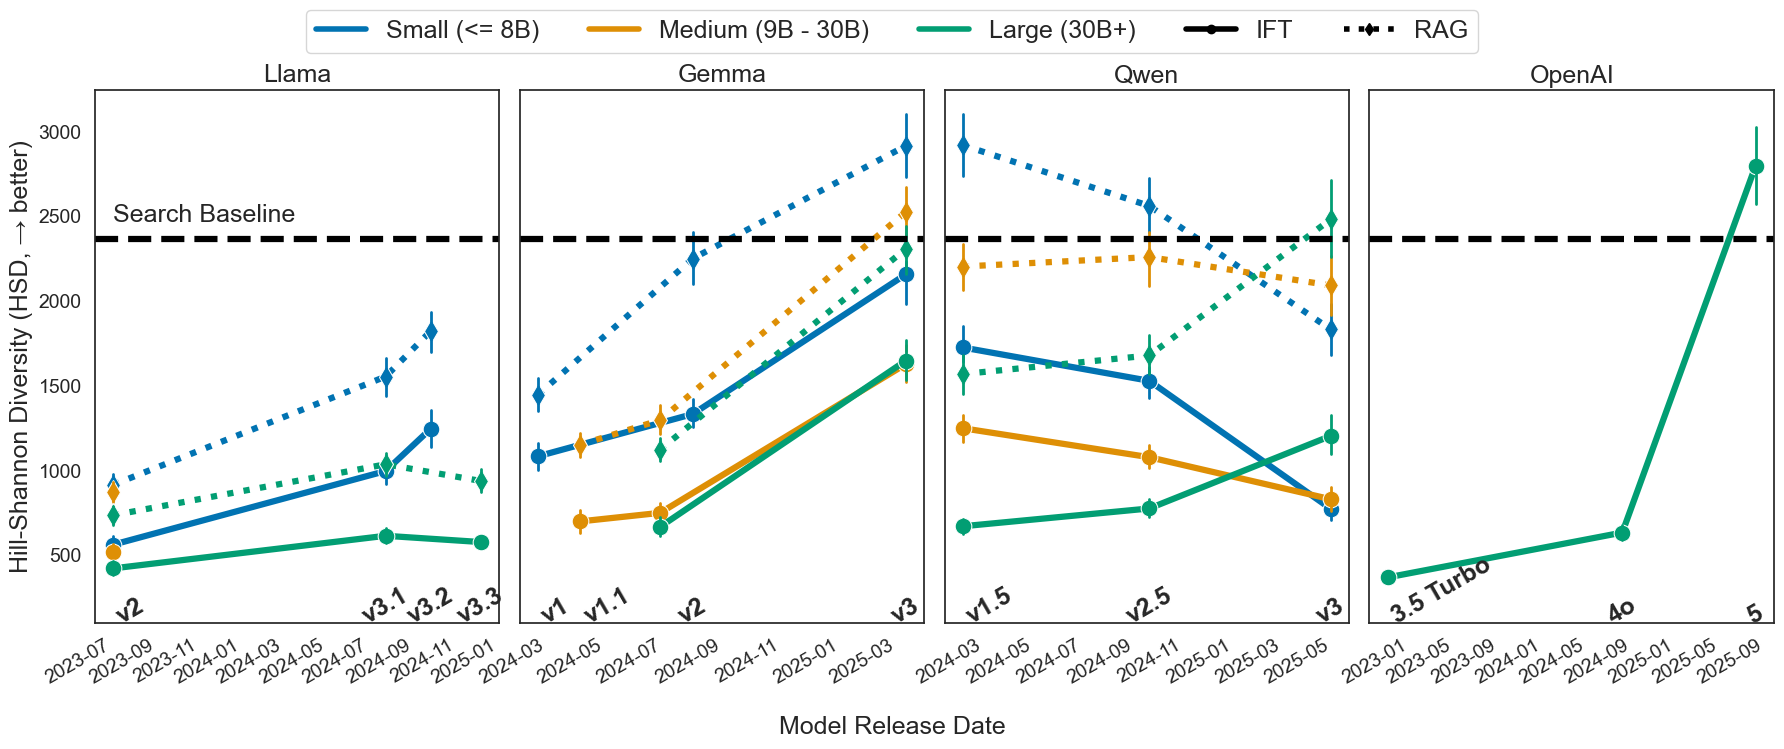

In [2006]:
# Create plot frame
fig, ax = plt.subplots(1,4, figsize=(18,7), sharey=True)
#fig, ax = plt.subplots(2,2, figsize=(9,9), sharey=True)
#ax = [a for r in ax for a in r]
typ = 'ift'
metric = 'hillshannon'
linestyle = {
    'ift': '-',
    'rag': ':'
}

marker = {
    'ift': 'o',
    'rag': 'd'
}
palette = sns.color_palette('colorblind')
colors = {
    'small': palette[0],
    'medium': palette[1],
    'large': palette[2]
}
search_starts = [
    "01-07-2023",
    "01-03-2024",
    "01-03-2024",
    "01-01-2023"
]
linewidth = 4.5
fontsize = 18
markersize = 12
errwidth = 2
# Start by separating by model version
all_dates = []
entropies = []
for j,family in enumerate(model_categories):
    labeled = set()
    for setting in model_categories[family]:
        # Get the F1 scores for each model in this family/setting
        scores = [s for model in model_categories[family][setting]['models'] for s in model_stats[typ][model][metric]]
        entropies.extend([e for model in model_categories[family][setting]['models'] for e in model_stats[typ][model]['entropy']])
        dates = [pd.to_datetime(d, dayfirst=True) for d,model in zip(model_categories[family][setting]['dates'], model_categories[family][setting]['models']) for s in model_stats[typ][model][metric]]

        # if any(['gemma-3' in model for model in model_categories[family][setting]['models']]):
        #     dates = dates[:-1]
        all_dates.extend(dates)
        if len(scores) > 0:
            sns.lineplot(
                x=dates, 
                y=scores, 
                ax=ax[j], 
                color=colors[setting], 
                marker=marker[typ], 
                ls=linestyle[typ], 
                err_style='bars', 
                linewidth=linewidth, 
                markersize=markersize, 
                err_kws = {'linewidth': errwidth}
            )

        # xlim = ax[j].get_xlim()[1]
        # ylim = ax[j].get_ylim()[0]
        # old_score = -1
        # for k,model in enumerate(model_categories[family][setting]['models']):
        #     #if 'gemma-3' not in model:
        #     score = np.mean(model_stats[typ][model][metric])
        #     offset = 5 if k == 0 or score > old_score else -5
        #     old_score = score
        #     original_name = model_to_name[model].replace(family_to_name[family], 'v')
        #     if 'openai' not in family:
        #         version = original_name.split(' ')[0]
        #         size = original_name.split(' ')[1]
        #     else:
        #         version = original_name

            
        #     # ann = ax[j].annotate(
        #     #     xy=(pd.to_datetime(model_categories[family][setting]['dates'][k], dayfirst=True),score), 
        #     #     xytext=(-3 if k > 0 else 3,offset),
        #     #     text=model_to_name[model].replace(family_to_name[family], 'v'), 
        #     #     ha='right' if k > 0 else 'left', textcoords='offset points',
        #     #     fontsize=fontsize
        #     # )
        #     if version not in labeled:
        #         ann = ax[j].annotate(
        #             xy=(pd.to_datetime(model_categories[family][setting]['dates'][k], dayfirst=True),ylim), 
        #             #xytext=(-3 if k > 0 else 3,offset),
        #             text=version, 
        #             ha='center',
        #             fontsize=fontsize,
        #             rotation=45
        #         )
        #         labeled.add(version)
            # See if the annotation is outside the window
            # extent = ax[j].transData.inverted().transform(ann.get_window_extent())
            # diff = extent[1][0] - xlim
            # if diff > 0:
            #     ann.set_x(extent[0][0] - diff)
    for setting in model_categories[family]:
        xlim = ax[j].get_xlim()[1]
        ylim = ax[j].get_ylim()[0]
        old_score = -1
        for k,model in enumerate(model_categories[family][setting]['models']):
            #if 'gemma-3' not in model:
            score = np.mean(model_stats[typ][model][metric])
            offset = 5 if k == 0 or score > old_score else -5
            old_score = score
            original_name = model_to_name[model].replace(family_to_name[family], 'v')
            if 'openai' not in family:
                version = original_name.split(' ')[0]
                size = original_name.split(' ')[1]
            else:
                version = ' '.join(original_name.split(' ')[1:])
    
            
            # ann = ax[j].annotate(
            #     xy=(pd.to_datetime(model_categories[family][setting]['dates'][k], dayfirst=True),score), 
            #     xytext=(-3 if k > 0 else 3,offset),
            #     text=model_to_name[model].replace(family_to_name[family], 'v'), 
            #     ha='right' if k > 0 else 'left', textcoords='offset points',
            #     fontsize=fontsize
            # )
            if version not in labeled:
                ann = ax[j].annotate(
                    xy=(pd.to_datetime(model_categories[family][setting]['dates'][k], dayfirst=True),100), 
                    #xytext=(-3 if k > 0 else 3,offset),
                    text=version, 
                    ha='center' if k > 0 else 'left',
                    fontsize=fontsize,
                    rotation=30,
                    weight='bold'
                )
                labeled.add(version)
                # See if the annotation is outside the window
                extent = ax[j].transData.inverted().transform(ann.get_window_extent())
                diff = extent[1][0] - xlim
                if diff > 0:
                    ann.set_x(extent[0][0] - diff)

typ='rag'
for j,family in enumerate(model_categories):
    for setting in model_categories[family]:
        # Get the F1 scores for each model in this family/setting
        if family != 'openai':
            scores = [s for model in model_categories[family][setting]['models'] for s in model_stats[typ][model][metric]]
            entropies.extend([e for model in model_categories[family][setting]['models'] for e in model_stats[typ][model]['entropy']])
            dates = [pd.to_datetime(d, dayfirst=True) for d,model in zip(model_categories[family][setting]['dates'], model_categories[family][setting]['models']) for s in model_stats[typ][model][metric]]

            # if any(['gemma-3' in model for model in model_categories[family][setting]['models']]):
            #     dates = dates[:-1]
            all_dates.extend(dates)
            if len(scores) > 0:
                sns.lineplot(
                    x=dates, 
                    y=scores, 
                    ax=ax[j], 
                    color=colors[setting], 
                    marker=marker[typ], 
                    ls=linestyle[typ], 
                    err_style='bars', 
                    linewidth=linewidth, 
                    markersize=markersize, 
                    err_kws = {'linewidth': errwidth}
                )
                #sns.lineplot(x=range(len(dates)), y=scores, ax=ax, label=f"{family}-{setting}", marker="d", ls='-.')
    ax[j].set_title(family_to_name[family], fontsize=fontsize)

entropies.extend([e for e in model_stats['other']['search']['entropy']])
for j,a in enumerate(ax):
    a.axhline(np.mean(model_stats['other']['search'][metric]), ls='--', color='black', label='search', linewidth=linewidth)
    a.tick_params(axis='both', which='major', labelsize=14)
    if j == 0:
        a.text(x=pd.to_datetime(search_starts[j], dayfirst=True), y=np.mean(model_stats['other']['search'][metric])+100, s="Search Baseline", fontsize=fontsize)
fig.autofmt_xdate()
ax[0].set_ylabel("Hill-Shannon Diversity (HSD, → better)", fontsize=fontsize)
#fig.supylabel("Hill-Shannon Diversity (HSD)", fontsize=fontsize)
fig.supxlabel("Model Release Date", fontsize=fontsize)
legend_lines = []
legend_labels = []
legend_dict = {
    'small': 'Small (<= 8B)',
    'medium': 'Medium (9B - 30B)',
    'large': 'Large (30B+)'
}
for name in colors:
    legend_lines.append(Line2D([0], [0], color=colors[name], lw=4))
    legend_labels.append(legend_dict[name])
for name in linestyle:
    legend_lines.append(Line2D([0], [0], color='black', ls=linestyle[name], marker=marker[name], lw=4))
    legend_labels.append(name.upper())
fig.legend(legend_lines, legend_labels, fontsize=18)
ylim = ax[0].get_ylim()
ax[0].set_ylim(100, ylim[1])

plt.tight_layout()
lgd = sns.move_legend(
    fig, "upper center",
    ncol=5, title=None, fontsize=18, bbox_to_anchor=(0.5, 1.07)
)
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig('figures/id_by_model.pdf', bbox_extra_artists=(lgd), bbox_inches='tight')
#ax.set_xticks([0,1,2], [1,2,3])

# RQ2: Overlap between different settings

In [1210]:
# Calculate pairwise JSDs
allmodels = list(model_to_name.keys())
heatmap = []
for k in tqdm(range(len(allmodels))):
    if k > 0:
        heatmap.append([0]*k)
    else:
        heatmap.append([])
    for j in range(k, len(allmodels)):
        if len(model_stats['ift' if allmodels[k] != 'search' else 'other'][allmodels[k]]['probabilities']) > 0 and len(model_stats['ift' if allmodels[j] != 'search' else 'other'][allmodels[j]]['probabilities']) > 0:
            p1 = model_stats['ift' if allmodels[k] != 'search' else 'other'][allmodels[k]]['probabilities']
            p2 = model_stats['ift' if allmodels[j] != 'search' else 'other'][allmodels[j]]['probabilities']
            heatmap[-1].append(np.array([jensenshannon(p1[n], p2[n]) for n in range(len(p1))]).mean())
        else:
            heatmap[-1].append(0)
heatmap = np.array(heatmap)                 

100%|███████████████████████████████████████████| 28/28 [00:52<00:00,  1.89s/it]


In [1211]:
heatmap = heatmap + heatmap.T - np.diag(np.diag(heatmap))

In [1340]:
def generate_heatmap(arrays, labels_x, labels_y, labels_values, ax, cmap, colorbar_ticks=None, title=None):

    sns.heatmap(arrays, annot=labels_values, ax=ax, cmap=cmap, fmt='.2f', cbar=True, annot_kws={"fontsize":28},
               cbar_kws={"pad":0.01, 'shrink': 0.8}, mask=arrays == 0.)
    # TODO set colorbar labels
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    if colorbar_ticks:
        ax.collections[0].colorbar.set_ticks([np.array(arrays).min(), np.array(arrays).max()], labels=colorbar_ticks)
    ax.set_yticks(ax.get_yticks(), labels=labels_y, rotation='horizontal', fontsize=28)
    if labels_x != None:
        ax.set_xticks(ax.get_xticks(), labels=labels_x, rotation='vertical', fontsize=28)
    else:
        ax.set_xticks([])
    ax.set_title(title)

def generate_heatmap_multiple(arrays, labels_x, labels_y, labels_values, axs, cmap, colorbar_ticks=None, title=None):

    for k,ax in enumerate(axs):
        
        sns.heatmap(arrays[k], annot=labels_values[k], ax=ax, cmap=cmap[k], fmt='.2f', cbar=False, annot_kws={"fontsize":14},
                   cbar_kws={"pad":0.01, 'shrink': 0.8}, mask=arrays[k] == 0.)
        # TODO set colorbar labels
        if colorbar_ticks:
            ax.collections[0].colorbar.set_ticks([min(arrays[k]), max(arrays[k])], labels=colorbar_ticks[k])
        ax.set_yticks(ax.get_yticks(), labels=labels_y[k], rotation='horizontal')
        #if k == len(axs) - 1:
        ax.set_xticks(ax.get_xticks(), labels=labels_x[k], rotation='vertical')
        #ax.set_xlabel("Question")
        if k == 0:
            ax.set_title(title)

In [1644]:
# Calculate pairwise JSDs
heatmap = []
labels = []
models_to_plot = [
    ('ift', 'meta-llama/Llama-3.2-3B-Instruct'),
    ('ift', 'google/gemma-3-1b-it'),
    ('ift', 'Qwen/Qwen1.5-7B-Chat'),
    ('ift', 'gpt-5-2025-08-07'),
    ('other', 'search')
]
for k in tqdm(range(len(models_to_plot))):
    if k > 0:
        heatmap.append([0]*k)
    else:
        heatmap.append([])
    for j in range(k, len(models_to_plot)):
        m1 = models_to_plot[k]
        m2 = models_to_plot[j]
        
        p1 = model_stats[m1[0]][m1[1]]['probabilities']
        p2 = model_stats[m2[0]][m2[1]]['probabilities']
        heatmap[-1].append(np.array([jensenshannon(p1[n], p2[n]) for n in range(len(p1))]).mean())
heatmap = np.array(heatmap)
heatmap = heatmap + heatmap.T - np.diag(np.diag(heatmap))
labels = [model_to_name[m[1]] for m in models_to_plot]

100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


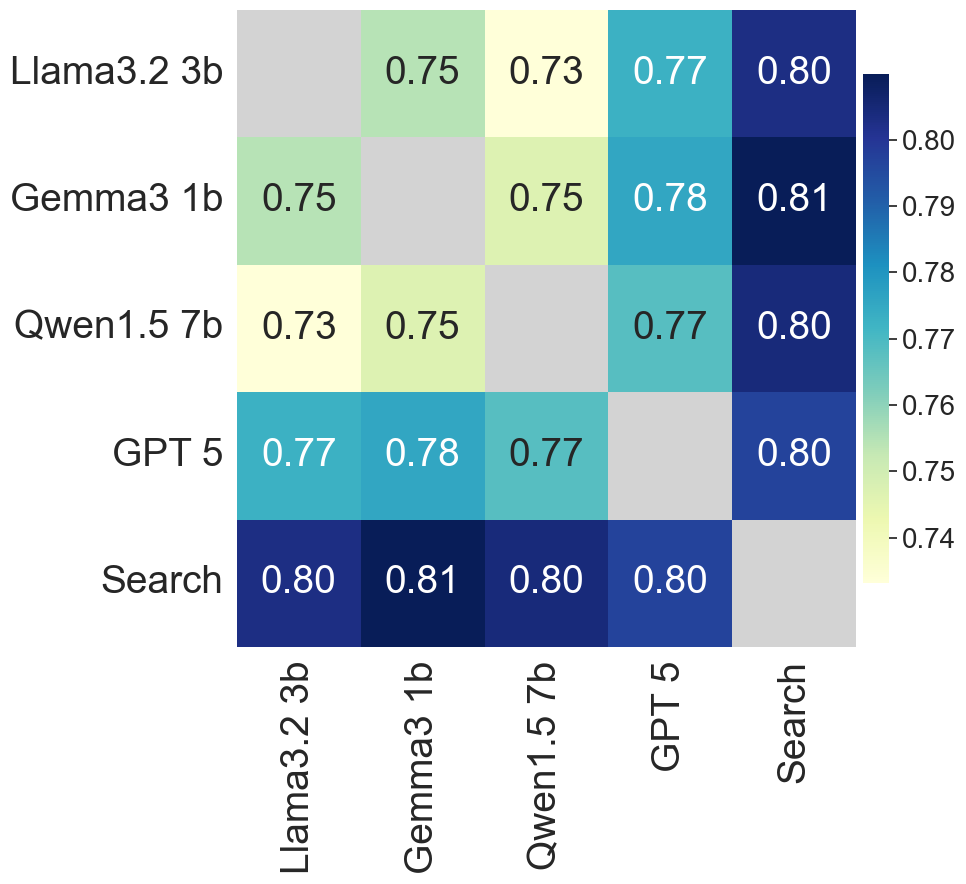

In [1647]:
fig, ax = plt.subplots(1,1, figsize=(10,9))
cmap = mpl.colormaps.get_cmap("YlGnBu")
cmap.set_bad("lightgrey")
generate_heatmap(heatmap, labels, labels, heatmap, ax, cmap)
#fig.suptitle("Jensen-Shannon Divergence between most diverse models")
plt.tight_layout()
plt.savefig("./figures/overlap_jsd.pdf")

# Regressions

In [1280]:
def extract_coefficients(lm, df):
    all_names = set([str(c) for c in df['category']])
    print(all_names)
    param_values = {}
    for n,p in lm.params.items():
        if '.' in n:
            name = '.'.join(n.split('.')[1:])[:-1]
            all_names.remove(name)
        else:
            name = n
        param_values[name] = (p, lm.pvalues[n])
    param_values[f"{list(all_names)[0]}"] = param_values.pop('Intercept')
    return param_values

def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    se = results.bse
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"p value":pvals,
                               "coeff":coeff,
                               "SE":se,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df.reset_index()
    results_df['term'] = results_df['index']
    return results_df

def add_star(p):
    sig = ' '
    if p < 0.05:
        sig = '*'
    else:
        sig = ' '
    if p < 0.01:
        sig = '**'
    if p < 0.001:
        sig = '***'
   
    return sig


def get_reference(df, categories):
    avail_cats = set(df['term'])
    return list(categories - avail_cats)[0]

        
def plot_reg_results(df, nrows = 1, ncols = 1, figsize=(4, 2), xlabel='xlabel', labels = None, title='', filename=None):
    #df = df.sort_values('coeff')
    xs = df['coeff']
    norm = mpl.colors.Normalize(vmin=min(xs)*2, vmax=max(xs)*2)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
    colors = np.array([(mapper.to_rgba(v)) for v in xs])
    en_len = int(len(df))
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes=[axes] if nrows + ncols <= 2 else axes
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.6)
    #plt.title(title)
    st = fig.suptitle("", fontsize=14)
    #sigg = fig.suptitle("Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1", fontsize=14)
    for i in range(len(axes)):
        ax = axes[i]
        ax.set_ylim(-0.7, len(df['term'][:en_len])-0.2)
        ax.axvline(x=0.00,color='black',linewidth=1.7,linestyle='-')
        ax.xaxis.grid(True)
        ax.yaxis.label.set_color('white')
        #ax.set_xticks([-0.5, 0.0, 0.5, 1,0])
        #ax.set_xlabel(r"%s ($\beta$ coef.)"%xlabel, fontsize=14)
        ax.set_xlabel(xlabel,fontsize=14)
        #ax.set_xticks([-0.04, -0.02, 0, 0.02, 0.04])
        #ax.set_title(r"%s"%(labels[i] if labels else dvs[i]), fontsize=14)
        s = en_len*i
        en = en_len*(i+1)
        for x, y, e, p, color in zip(df['coeff'][s:en], df['term'][s:en], df['SE'][s:en],df['p value'][s:en], colors[s:en]):
            #plt.plot(x, y, 'o', color=color)
            ax.errorbar(x=[x], y=[y], xerr=[e], color=color,fmt='o')
            sig = ' '
            if p < 0.05:
                sig = '*'
            if p < 0.01:
                sig = '**'
            if p < 0.001:
                sig = '***'
            ax.annotate(sig, # this is the text
                     (x+0.00001,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,-0.5), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

        #ax.set_xticklabels([-0.04, -0.02, 0, 0.02, 0.04], fontsize=14)
        ax.set_yticklabels(list(df['term']), fontsize=14)
        ax.spines['bottom'].set_color('0.')
        ax.spines['top'].set_color('0.')
        ax.spines['right'].set_color('0.')
        ax.spines['left'].set_color('0.')
        ax.set_facecolor('white')

    #fig.text(0.5, 0.04, 'common X', ha='center')
    st.set_y(-0.02)
    #sigg.set_y(-0.12)
    fig.text(0.5, -0.14, s="%s"%title,ha='center',fontsize=14)
    fig.text(0.5, -0.18, s="Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05",ha='center',fontsize=9)
    if filename:
        #plt.tight_layout()
        plt.savefig(filename, bbox_inches='tight')

In [2007]:
ols_data = []
metric = 'hillshannon'
for typ in ['ift', 'rag']:
    typename = 'IFT' if typ == 'ift' else 'RAG'
    for j,family in enumerate(model_categories):
        for setting in model_categories[family]:
            # Get the F1 scores for each model in this family/setting
            for k,model in enumerate(model_categories[family][setting]['models']):
                if not (typename == 'RAG' and 'openai' in family):
                    for n,s in enumerate(model_stats[typ][model][metric]):
                        ols_data.append([setting[0].upper() + setting[1:], model_to_name[model], family_to_name[family], 
                                         model_categories[family][setting]['size'][k], 
                                         pd.to_datetime(model_categories[family][setting]['dates'][k], dayfirst=True).to_julian_date(),
                                         k+1,
                                         typename,
                                         f"{model_to_name[model]} {typename}",
                                         topic_to_country[model_stats[typ][model]['topic'][n]],
                                         model_stats[typ][model]['topic'][n],
                                         s]
                        )
    
                    # if 'openai' not in family:
                    #     for n,s in enumerate(model_stats['rag'][model]['f1']):
                    #         ols_data.append([model_to_name[model], family_to_name[family], 
                    #                          model_categories[family][setting]['size'][k], 
                    #                          pd.to_datetime(model_categories[family][setting]['dates'][k], dayfirst=True).to_julian_date(),
                    #                          k+1,
                    #                          'RAG',
                    #                          f"{model_to_name[model]} RAG",
                    #                          topic_to_country[model_stats['rag'][model]['topic'][n]],
                    #                          model_stats['ift'][model]['topic'][n],
                    #                          s]
                    #         )

for n,s in enumerate(model_stats['other']['search'][metric]):
    ols_data.append(['None',model_to_name['search'], 'Search', 
                     -1, 
                     -1,
                     -1,
                     'Search',
                     'Search',
                     topic_to_country[model_stats['other']['search']['topic'][n]],
                     model_stats['ift'][model]['topic'][n],
                     s]
    )
ols_dframe = pd.DataFrame(ols_data, columns=['size_class', 'model', 'family', 'size', 'date', 'version', 'setting', 'model_setting', 'country', 'topic', 'f1'])


### Modality

                              Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              f1         
No. Observations:                8008                 Method:                          REML       
No. Groups:                      28                   Scale:                           558368.0899
Min. group size:                 154                  Log-Likelihood:                  -64403.0791
Max. group size:                 308                  Converged:                       Yes        
Mean group size:                 286.0                                                            
--------------------------------------------------------------------------------------------------
                                                   Coef.    Std.Err.   z    P>|z|  [0.025  0.975] 
--------------------------------------------------------------------------------------------------
Intercept                                

/var/folders/2t/bns057gs0ss5_m20xzbdwvwmb9fq40/T/ipykernel_30840/1892249030.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['term'] = ['.'.join(it.split('.')[1:])[:-1] for it in t_df['term']]
/var/folders/2t/bns057gs0ss5_m20xzbdwvwmb9fq40/T/ipykernel_30840/1968518019.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(df['term']), fontsize=14)


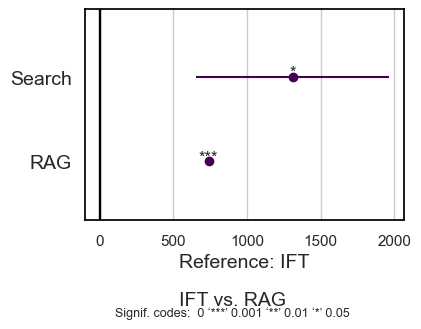

In [2010]:
dframe_test = ols_dframe#[ols_dframe['setting'].isin(['IFT', 'RAG'])]
# f1_lm = ols(f'f1 ~ C(model_setting, Treatment(reference="Search"))',
#                      data=dframe_test).fit()
# Uncomment and check when we have more data -- adding a random effect for the model
f1_lm = mixedlm(f'f1 ~ C(setting, Treatment(reference="IFT"))',
                     data=dframe_test, groups=dframe_test['model']).fit()
print(f1_lm.summary())
res_df = results_summary_to_dataframe(f1_lm)
t_df = res_df[res_df['term'].str.contains('setting')]
t_df['term'] = ['.'.join(it.split('.')[1:])[:-1] for it in t_df['term']]
reference = get_reference(t_df, set(dframe_test['setting']))
#t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
plot_reg_results(t_df, title='IFT vs. RAG', xlabel=f'Reference: {reference}',figsize=(4,2.8), filename=f'./figures/modality_regression.pdf')

### Size

                                 Mixed Linear Model Regression Results
Model:                             MixedLM                Dependent Variable:                f1         
No. Observations:                  7854                   Method:                            REML       
No. Groups:                        2                      Scale:                             849626.0576
Min. group size:                   3696                   Log-Likelihood:                    -64748.4707
Max. group size:                   4158                   Converged:                         Yes        
Mean group size:                   3927.0                                                               
--------------------------------------------------------------------------------------------------------
                                                        Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------------------------------

/var/folders/2t/bns057gs0ss5_m20xzbdwvwmb9fq40/T/ipykernel_30840/207332655.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['term'] = ['.'.join(it.split('.')[1:])[:-1] for it in t_df['term']]
/var/folders/2t/bns057gs0ss5_m20xzbdwvwmb9fq40/T/ipykernel_30840/1968518019.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(df['term']), fontsize=14)


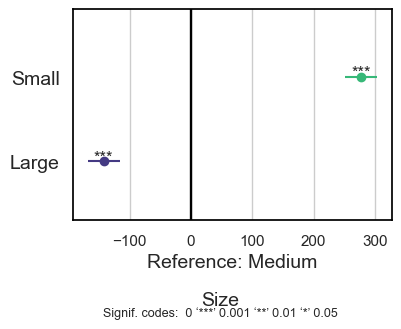

In [2011]:
dframe_test = ols_dframe[ols_dframe['setting'].isin(['IFT', 'RAG'])]
# f1_lm = ols(f'f1 ~ C(size, Treatment(reference="small"))',
#                      data=dframe_test).fit()
# Uncomment and check when we have more data -- adding a random effect for the model
f1_lm = mixedlm(f'f1 ~ C(size_class, Treatment(reference="Medium"))',
                     data=dframe_test, groups=dframe_test['setting']).fit()
print(f1_lm.summary())
res_df = results_summary_to_dataframe(f1_lm)
t_df = res_df[res_df['term'].str.contains('size_class')]
t_df['term'] = ['.'.join(it.split('.')[1:])[:-1] for it in t_df['term']]
reference = get_reference(t_df, set(dframe_test['size_class']))
#t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
plot_reg_results(t_df, title='Size', xlabel=f'Reference: {reference}',figsize=(4,2.8), filename=f'./figures/size_regression.pdf')

### Country

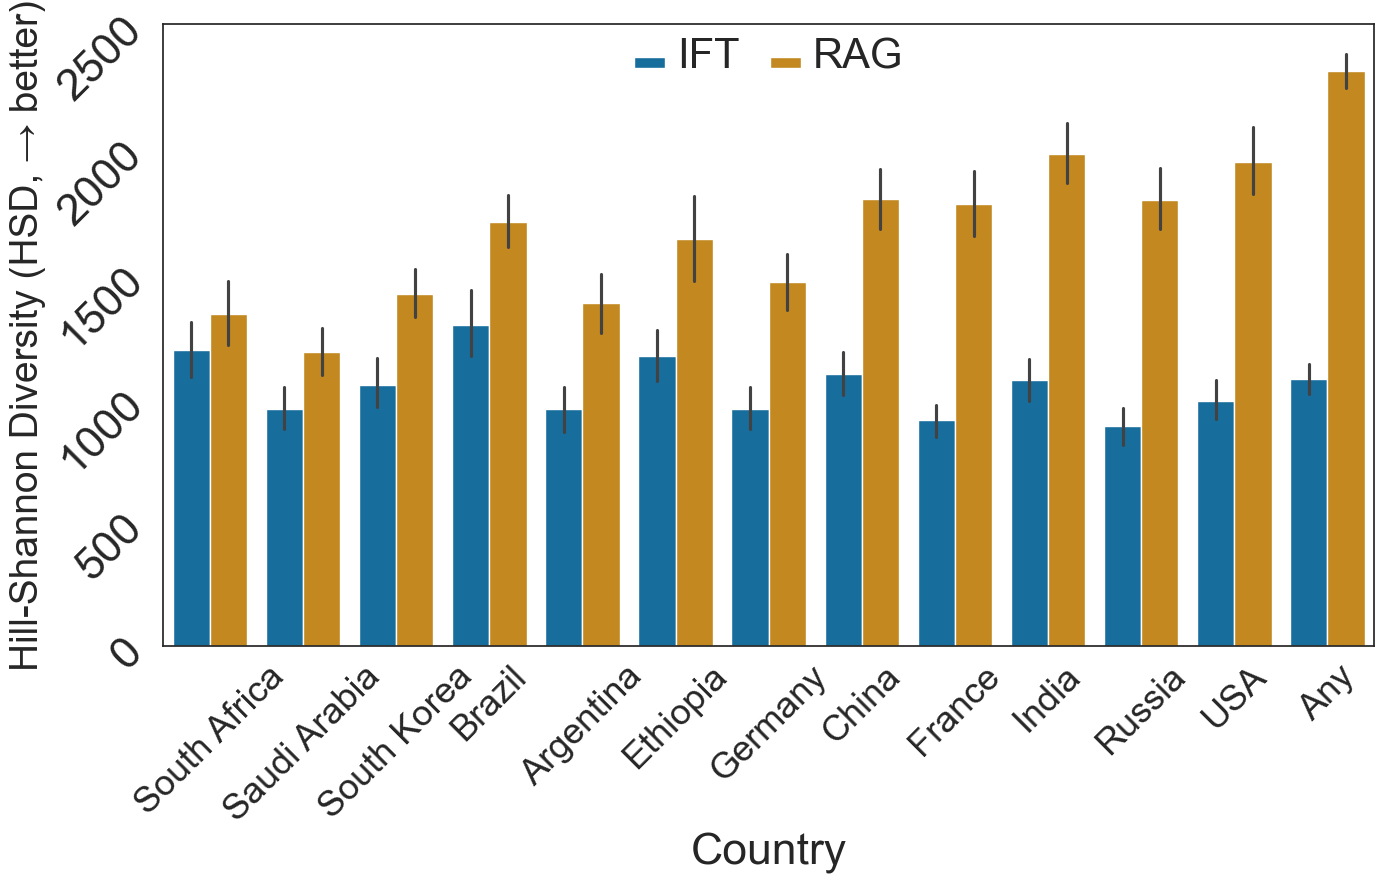

In [2013]:
fig, ax = plt.subplots(1,1, figsize=(14,9))
dframe_test = ols_dframe.copy()
dframe_test = dframe_test[dframe_test['setting'].isin(['IFT', 'RAG'])]
# Get the order
countries = list(set(dframe_test['country'].to_list()))
scores = []
for c in countries:
    ift = dframe_test[(dframe_test['country'] == c) & (dframe_test['setting'] == 'IFT')]
    rag = dframe_test[(dframe_test['country'] == c) & (dframe_test['setting'] == 'RAG')]
    scores.append(np.array(rag['f1']).mean() - np.array(ift['f1']).mean())
order = np.array(countries)[np.argsort(scores)]#[np.argsort(countries)]
#ift_hist_data = dframe_test[dframe_test['setting'] == 'IFT']
sns.barplot(dframe_test, x='country', y='f1', hue='setting', palette='colorblind', order=order)
ax.set_xlabel("Country", fontsize=32)
ax.set_ylabel("Hill-Shannon Diversity (HSD, → better)", fontsize=28)
plt.xticks(rotation=45, fontsize=26)
plt.yticks(rotation=45, fontsize=32)

sns.move_legend(
    ax, "upper center",
    ncol=3, title=None, frameon=False,
)
plt.setp(ax.get_legend().get_texts(), fontsize='30') # for legend text
plt.tight_layout()
plt.savefig("figures/country_diversity_bar.pdf")

In [1639]:
ift_to_div = {}
for name,group in ols_dframe[ols_dframe['setting'] == 'IFT'].groupby('country'):
    ift_to_div[name] = group['f1'].mean()
rag_to_div = {}
for name,group in ols_dframe[ols_dframe['setting'] == 'RAG'].groupby('country'):
    rag_to_div[name] = group['f1'].mean()
search_to_div = {}
for name,group in ols_dframe[ols_dframe['setting'] == 'Search'].groupby('country'):
    search_to_div[name] = group['f1'].mean()

to_corr = []
for c in search_to_div:
    to_corr.append([rag_to_div[c] - ift_to_div[c], search_to_div[c]])
to_corr = np.array(to_corr)

In [1640]:
from scipy.stats import pearsonr

pearsonr(to_corr[:,0], to_corr[:,1])

PearsonRResult(statistic=0.7293681519416859, pvalue=0.0046655408874464906)

# RQ4.2: Wikipedia matching

In [1922]:
wiki_data = pd.read_parquet('./data/geval_output/WIKI_NLI_OUTPUT_GTP5_1.pqt')
wiki_en = pd.read_parquet('./data/geval_output/WIKI_NLI_USA_ANY_OUTPUT_GTP5_1_ROW_CLEANED.pqt')

wiki_data = pd.concat([wiki_data, wiki_en]).reset_index(drop=True)

In [1935]:
en_cluster_key = 'EN_Top_Dedup_clusters'
en_nli_key = 'EN_NLI_GPT5_1'
multi_cluster_key = 'MUL_Top_Dedup_clusters'
multi_nli_key = 'MUL_NLI_GPT5_1'

en_to_clusters = defaultdict(set)
en_to_length = {}
multi_to_clusters = defaultdict(set)
multi_to_length = {}
for j,row in wiki_data.iterrows():
    # multi
    if row['country'] not in ['USA', 'Any']:
        multi_to_clusters[row['matched_topic']] = set([c[0] for csec,nsec in zip(row[multi_cluster_key], row[multi_nli_key]) for c,n in zip(csec,nsec) if n[0] == 'yes'])
        multi_to_length[row['matched_topic']] = len([c for csec,nsec in zip(row[multi_cluster_key], row[multi_nli_key]) for c,n in zip(csec,nsec)])

    en_to_clusters[row['matched_topic']] = set([c[0] for csec,nsec in zip(row[en_cluster_key], row[en_nli_key]) for c,n in zip(csec,nsec) if n[0] == 'yes'])
    en_to_length[row['matched_topic']] = len([c for csec,nsec in zip(row[en_cluster_key], row[en_nli_key]) for c,n in zip(csec,nsec)])

    

In [2014]:
# Calculate all of the entropies
en_topic_to_div = defaultdict(list)
multi_topic_to_div = defaultdict(list)
models = []
families = []
models_added = False
for k,t in enumerate(tqdm(topics)):
    if t not in en_to_clusters:
        continue
    # Read in the topic dframe
    if Path(f"{cluster_dir}/{t}.done").exists():
        dframe = pd.read_parquet(f"{cluster_dir}/{t}.pqt")
        en_dframe = dframe.copy()
        en_dframe = en_dframe[en_dframe['cluster'].isin(en_to_clusters[t])]
        # Do the same for multi
        multi_dframe = dframe.copy()
        multi_dframe = multi_dframe[multi_dframe['cluster'].isin(multi_to_clusters[t])]
        present_models = set(dframe['model_id'].to_list())
        # Go through all of the models and calculate the scores
        for family in model_categories:
            for setting in model_categories[family]:
                for model in model_categories[family][setting]['models']:
                    if model not in present_models:
                        continue
                    ent,hillshannon,probs = calculate_diversity(en_dframe, group_keys=['model_id', 'setting'], group_values=[model, 'ift'], return_type='list')
                    en_topic_to_div[t].append(hillshannon)

                    if topic_to_country[t] not in ['USA', 'Any']:
                        ent,hillshannon,probs = calculate_diversity(multi_dframe, group_keys=['model_id', 'setting'], group_values=[model, 'ift'], return_type='list')
                        multi_topic_to_div[t].append(hillshannon)
                    else:
                        multi_topic_to_div[t].append(0.)
                    if not models_added:
                        models.append(model)
                        families.append(family)
    models_added = True
                

100%|█████████████████████████████████████████| 155/155 [01:14<00:00,  2.08it/s]


In [2015]:
plotting_dframe = []
for t in topics:
    if t not in en_to_clusters:
        continue
    for es,ms,mod,fam in zip(en_topic_to_div[t], multi_topic_to_div[t], models, families):
        plotting_dframe.append([es, mod, topic_to_country[t], 'English', fam])
        plotting_dframe.append([ms, mod, topic_to_country[t], 'Local', fam])
plotting_dframe = pd.DataFrame(plotting_dframe, columns=['Diversity', 'Model', 'Country', 'Wikipedia', 'Family'])

In [2018]:
countries = ['Argentina', 'South Korea', 'Russia', 'France', 'India', 'Brazil', 'China', 'Germany', 'USA', 'Any']
scores = []
for c in countries:
    curr = plotting_dframe[plotting_dframe['Country'] == c]
    eng = curr[curr['Wikipedia'] == 'English']['Diversity'].to_numpy().mean()
    local = curr[curr['Wikipedia'] == 'Local']['Diversity'].to_numpy()
    local = local.mean() if len(local) > 0 else 0.
    scores.append(eng - local)
sort_order = np.array(countries)[np.argsort(scores)]#[np.argsort(countries)]

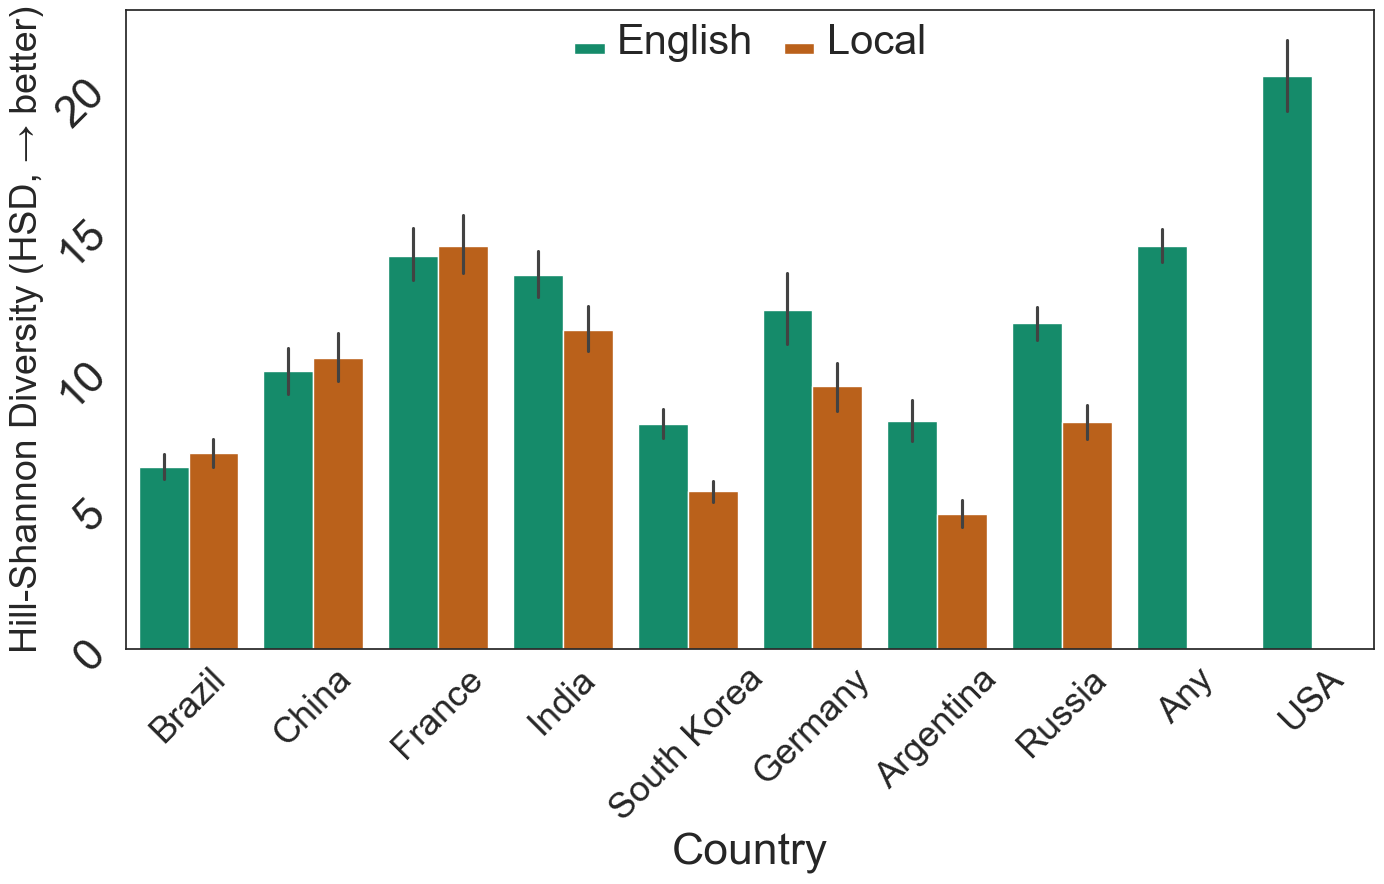

In [2023]:
fig, ax = plt.subplots(1,1, figsize=(14,9))
palette = [sns.color_palette('colorblind')[2], sns.color_palette('colorblind')[3]]
#ift_hist_data = dframe_test[dframe_test['setting'] == 'IFT']
sns.barplot(plotting_dframe, x='Country', y='Diversity', hue='Wikipedia', palette=palette, order=sort_order)
ax.set_xlabel("Country", fontsize=32)
ax.set_ylabel("Hill-Shannon Diversity (HSD, → better)", fontsize=27)
plt.xticks(rotation=45, fontsize=26)
plt.yticks(rotation=45, fontsize=32)

sns.move_legend(
    ax, "upper center",
    ncol=3, title=None, frameon=False,
)
plt.setp(ax.get_legend().get_texts(), fontsize='30') # for legend text
plt.tight_layout()
plt.savefig("figures/id_by_country.pdf")